# Нейросеть для автодополнения текстов

Проект направлен на обучение нейронной сети для автодополнения текста

Пропишим необходимые импорты и пути.

In [1]:
from collections import Counter

import pandas as pd

import re

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.model_selection import train_test_split

import evaluate

d:\Обучение\Обучение_DL\sprint_2_rnn\project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
PATH_ROW_DATA = 'data/raw_dataset.txt'
PATH_PROCESSED_DATA = 'data/processed.csv'
PATH_TRAIN_DATA = 'data/train.csv'
PATH_VALID_DATA = 'data/valid.csv'
PATH_TEST_DATA = 'data/test.csv'

In [3]:
RANDOM_SEED = 123

## EDA & Preprocessing

### Предобработка и исследование сырого датасета

Прочитаем данные и посмотрим, что они из себя представляют (выведем первые 10 строк)

In [4]:
with open(PATH_ROW_DATA, 'r', encoding='utf-8') as file:
    texts = file.readlines()

In [5]:
texts[:10]

["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D\n",
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!\n",
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds\n',
 'my whole body feels itchy and like its on fire \n',
 "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. \n",
 '@Kwesidei not the whole crew \n',
 'Need a hug \n',
 "@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?\n",
 "@Tatiana_K nope they didn't have it \n",
 '@twittera que me muera ? \n']

В данных видны следующие проблемы:
1. Некоторые данные начинаютс с указания аккаунта который писал данный твит, а некоторые нет, поэтому эту часть необходимо удалить.
2. Есть ссылки, поэтому их тоже необходимо зачистить.
3. Все твиты из выведенных заканчиваются симоволом переноса строки, это тоже необходимо будет почистить.
4. Есть смайлики. Необходимо посмотреть это только классические смайлики или ещё есть в формате \*смайлик\*.
5. Необходимо всё привести к нижнему регистру.

Напишем функцию, которая решает данные проблемы.

In [6]:
def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'\w*@\w*', ' ', text) # убираем указани аккаунта и почты
    text = re.sub(r'http\S*', ' ', text) # убираем адреса

    text = re.sub(r"[:;=]['\-]?[)d(p]+", ' ', text) # убираем классические смайлики
    text = re.sub(r'\*\w*\*', ' ', text) # убираем смайлики прописанные в формате слов
    # убираем самйлики в формате кодов
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags = re.UNICODE)
    text = regrex_pattern.sub(r'',text)

    text = re.sub(r'\s+([.,!?;:])', r'\1', text) # убираем висячие знаки припинания
    re.sub(r'([.,!?;:])([^\s])', r'\1 \2', text) # добавляем пробелы после знаков припинания, если их нет

    # заменяем все возможные пробелы, переносы и т.д. на стандартный символ пробела и затем заменяем 2 и более пробелов на 1
    text = re.sub(r'_x000d_\n', ' ', text)
    text = re.sub(r'^\s+|\n', ' ', text)
    text = re.sub(r'  ', ' ', text)
    text = re.sub(r'^ +| +$', '', text) # убираем пробелы в начале и конце строки
    return text

Протестируем на первом примере

In [7]:
clean_text(texts[0])

"- awww, that's a bummer. you shoulda got david carr of third day to do it."

Всё отработало корректно. Почистим все данные и выведем первые 10 примеров.

In [8]:
texts = [clean_text(text) for text in tqdm(texts, desc='Очистка тестка')]

Очистка тестка: 100%|██████████| 1600498/1600498 [00:28<00:00, 55691.39it/s]


In [9]:
texts[:10]

["- awww, that's a bummer. you shoulda got david carr of third day to do it.",
 "is upset that he can't update his facebook by texting it... and might cry as a result school today also. blah!",
 'i dived many times for the ball. managed to save 50% the rest go out of bounds',
 'my whole body feels itchy and like its on fire',
 "no, it's not behaving at all. i'm mad. why am i here? because i can't see you all over there.",
 'not the whole crew',
 'need a hug',
 "hey long time no see! yes.. rains a bit,only a bit lol, i'm fine thanks, how's you?",
 "nope they didn't have it",
 'que me muera?']

Посчитаем количество слов в предложениях.

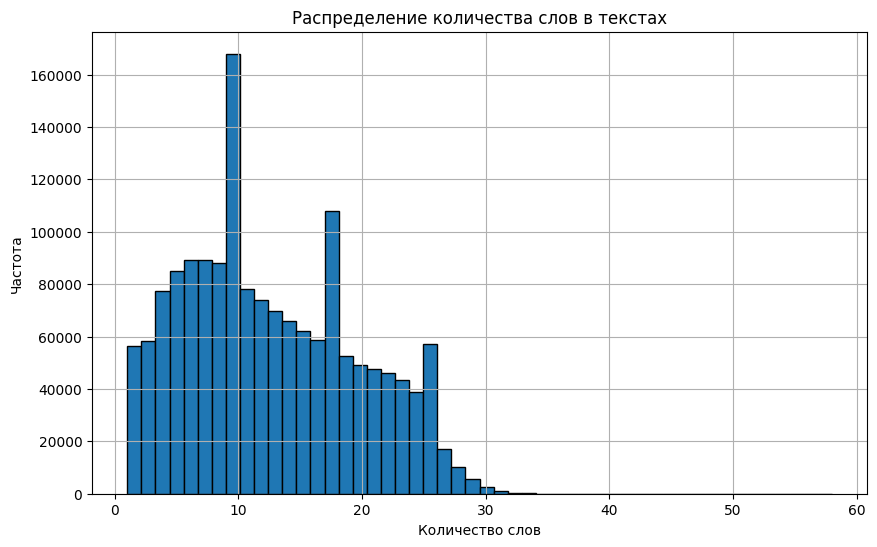

In [10]:
word_counts = [len(text.split(' ')) for text in texts]

plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=50, edgecolor='black')
plt.title("Распределение количества слов в текстах")
plt.xlabel("Количество слов")
plt.ylabel("Частота")
plt.grid(True)
plt.show() 

Большинство твитов укладывается в 25 слов, но есть редкие твиты в которых порядка 60 слов. Так же есть много твитов состоящих всего из одного ответа.

Посмотрим насколько часто каждое слово встречается в корпусе.

In [11]:
res = []
[res.extend(text.split(' ')) for text in texts]

count_of_words = Counter(res)

Посмотрим на наиболее частые слова

In [12]:
count_of_words.most_common(10)

[('i', 746521),
 ('to', 559693),
 ('the', 518791),
 ('a', 376435),
 ('my', 312797),
 ('and', 294971),
 ('you', 236376),
 ('is', 230816),
 ('for', 213738),
 ('in', 209807)]

Ожидаемо это местоимения, артикли и предлоги

Теперь на наиболее редкие

In [13]:
count_of_words.most_common()[:-10:-1]

[('#flockofseagullsweregeopoliticallycorrect', 1),
 ('texn3rds', 1),
 ('calcio1', 1),
 ('indesign?:', 1),
 ('typeset', 1),
 ('waster)', 1),
 ('flay...', 1),
 ('(updated:', 1),
 ('$palm', 1)]

Редкими оказались хэштеги, опечатки, в том числе с заменок букв на цифры, просто редкие слова плюс слова со знаками препинания (но в этом виновата наша разбивка).

### Токенизация и создание датасетов

Теперь проведём токенизацию нашего датасета.

In [14]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [15]:
token_texts = [tokenizer(text, truncation=True)['input_ids'] for text in tqdm(texts, desc='Очистка тестка')]

Очистка тестка: 100%|██████████| 1600498/1600498 [02:25<00:00, 10995.21it/s]


Посмотрим на результат

In [16]:
token_texts[0]

[101,
 1011,
 22091,
 2860,
 2860,
 1010,
 2008,
 1005,
 1055,
 1037,
 26352,
 5017,
 1012,
 2017,
 2323,
 2050,
 2288,
 2585,
 12385,
 1997,
 2353,
 2154,
 2000,
 2079,
 2009,
 1012,
 102]

Иеперь нам необходимо сформировать два списка: один данные для обучения, второй - цели обучения.

In [ ]:
def get_data_and_target(token_texts: list[str]) -> tuple[list[str], list[str]]:
    set_tuple = set()
    data_list = []
    target_list = []
    for text in tqdm(token_texts, desc='Создание списков для обучения'):
        for idx_target in range(1, len(text)):
            # Добавляем только уникальные сочетания data/target чтобы избежать дублей
            item = ' '.join([str(i) for i in text[:idx_target + 1]])
            if (item) not in set_tuple:
                set_tuple.add(item)
                data_list.append(text[:idx_target])
                target_list.append(text[idx_target])
    return data_list, target_list

In [25]:
data_list, target_list = get_data_and_target(token_texts)

Создание списков для обучения: 100%|██████████| 1600498/1600498 [01:24<00:00, 18837.83it/s]


Посмотрим корректно ли всё отработало

In [26]:
data_list[:5]

[[101],
 [101, 1011],
 [101, 1011, 22091],
 [101, 1011, 22091, 2860],
 [101, 1011, 22091, 2860, 2860]]

In [27]:
target_list[:5]

[1011, 22091, 2860, 2860, 1010]

Всё отработало корректно. Теперь создадим датафрейм и сохраним его

In [28]:
df = pd.DataFrame({
    'data': data_list,
    'target': target_list
})
df.head()

,data,target
0,[101],1011
1,"[101, 1011]",22091
2,"[101, 1011, 22091]",2860
3,"[101, 1011, 22091, 2860]",2860
4,"[101, 1011, 22091, 2860, 2860]",1010


In [29]:
df.shape

(24982596, 2)

Сохраним полученный датафрейм

In [30]:
df.to_csv(PATH_PROCESSED_DATA, index=False)

Разделим датасет на тренировочный, валидационный и тестовый

In [31]:
df_train, df_test= train_test_split(df, test_size=0.4, random_state=RANDOM_SEED)
df_valid, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

Выведем размеры получившихся датасетов

In [32]:
df_train.shape, df_valid.shape, df_test.shape

((14989557, 2), (4996519, 2), (4996520, 2))

Сохраним их.